In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys
import os
import numpy as np # grey images are stored in memory as 2D arrays, color images as 3D arrays
import cv2 # opencv computer vision library
from skimage import io # for io.imread
from matplotlib import pyplot as plt # ploting
from matplotlib import colors # ploting
from scipy.spatial import Delaunay

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import random

from random import randint

from matplotlib.path import Path
from collections import Counter
from skimage import io

from scipy.spatial import distance
from skimage.feature import hog

import skimage.morphology
import mahotas
import os
import networkx as nx
import itertools

from scipy.optimize import minimize


In [4]:
#global classes #global methods : 



def threshold(img, value):
   """
   Delete noise and highligh the contours
   parameters:
      image : np.ndarray 
         image to denoise
      value : int
         treshold value of the pixel color
   returns:
      image denoised
   """
   return np.where(img <= value, 0, 255).astype(np.uint8)

def filling(i,j,classes_matrix,treated_pixels, class_num ):
    #private function
    stack = [(i,j)] #utilisation de stack car probleme avec la recursion

    while stack :
        x,y = stack.pop()
        if(classes_matrix[x][y] == 0):
            classes_matrix[x][y] = class_num
            treated_pixels[x][y] = True
            if(x != 0):
                #classes_matrix = filling(x-1,y,classes_matrix,treated_pixels, class_num)
                stack.append((x - 1, y))
            if(x != classes_matrix.shape[0]-1):
                #classes_matrix =filling(x+1,y,classes_matrix,treated_pixels, class_num)
                stack.append((x + 1, y))
            if(y != 0):
                #classes_matrix =filling(x,y-1,classes_matrix,treated_pixels, class_num)
                stack.append((x, y - 1))
            if(y != classes_matrix.shape[1]-1):
                #classes_matrix =filling(x,y+1,classes_matrix,treated_pixels, class_num)
                stack.append((x , y+ 1))
    return classes_matrix





def assign_class_to_pixel_by_filling(image, filling_function="basic_filling"):


    #create matrix of classes
    classes_matrix = np.zeros((image.shape[0], image.shape[1]))
    classes_matrix =  np.where(
    (image[..., 0] == 255) & 
    (image[..., 1] == 255) & 
    (image[..., 2] == 255),
    classes_matrix, -1)
   
    print(classes_matrix.shape)
    #imshow_cv(classes_matrix)
    
    last_class = 1
    classes_num_list = [1]
    treated_pixels = np.full_like(classes_matrix, False, dtype=bool)

    mask_contour = (classes_matrix == -1) # -1 is the value of contours 
    treated_pixels[mask_contour] = True        
    while(np.isin(classes_matrix,0).any()):
        #classes_matrix, new_treated_pixels = apply_class_in_matrix(classes_matrix, treated_pixels,last_class)
        #treated_pixels = new_treated_pixels.copy()
        fill = False
        for line in range(classes_matrix.shape[0]):
            for col in range(classes_matrix.shape[1]):#parcourir de la gauche 
                if(classes_matrix[line][col] == 0):
                    if(filling_function == "basic_filling"):
                        filling(line, col,classes_matrix, treated_pixels,last_class)
                    elif(filling_function == "delaunay_filling"):
                        delaunay_filling(line, col, classes_matrix, treated_pixels,last_class)
                    fill =True

                    break
            if(fill): break  
        #print("step",last_class-1)
        #imshow_cv(classes_matrix_to_image(classes_matrix, classes_num_list))
        #print(classes_matrix[200])
        #imshow_plt([classes_matrix_to_image(classes_matrix, classes_num_list)],['classe'+str(last_class)])
        
        
        last_class+=1
        classes_num_list.append(last_class)
    print("classe numbers:", last_class)

    return classes_matrix, classes_num_list

def extract_regions_by_class(classes_matrix):
    """
    Extrait les régions de pixels pour chaque classe dans la matrice de classes.
    """
    regions = {}
    #unique_classes = np.unique(classes_matrix)
    unique_classes = classes_matrix[classes_matrix >= 1]  # Exclure les contours (-1) et les pixels non classés (0)

    for class_num in unique_classes:
        mask = (classes_matrix == class_num)
        regions[class_num] = mask
    return regions

def enhance_lines_preserving_details(image, alpha=1, beta=1):
    """
    Enhance visible lines in an image while preserving the original details.

    Args:
        image (numpy.ndarray): Input image (BGR format).
        alpha (float): Contrast control (1.0-3.0).
        beta (int): Brightness control (0-100).

    Returns:
        numpy.ndarray: Image with enhanced lines.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a slight Gaussian blur to reduce noise without oversimplifying details
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)

    # Use the original image and adjust contrast and brightness
    enhanced = cv2.convertScaleAbs(blurred, alpha=alpha, beta=beta)

    # Convert back to 3-channel image for visualization
    result = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
    
    return result


def colored_to_line(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    inverted = 255 - gray
    blurred = cv2.GaussianBlur(inverted, (5,5),0)
    invertedblur = 255 - blurred
    lines = cv2.divide(gray, invertedblur, scale=256.0)
    return lines , cv2.cvtColor(lines, cv2.COLOR_GRAY2BGR)


#gloabl method :
def compute_similarity(desc1, desc2, color1=None, color2=None, color_tolerance=100):
    """
    Calcule la distance de similarité entre deux ClassDescriptor en fonction de leurs descripteurs, couleurs,
    voisins et patchs environnants.
    
    Parameters:
        desc1 (dict): Descripteurs de la première classe.
        desc2 (dict): Descripteurs de la seconde classe.
        color1 (tuple): Couleur RGB de la première classe.
        color2 (tuple): Couleur RGB de la seconde classe.
        color_tolerance (float): Tolérance pour considérer que les couleurs sont similaires.
    
    Returns:
        float: La distance de similarité entre les deux classes. Retourne float('inf') si les couleurs sont trop différentes.
    """
    # Vérification des couleurs
    if color1 is not None and color2 is not None:
        color_distance = np.linalg.norm(np.array(color1) - np.array(color2))
        if color_distance > color_tolerance:
            return float('inf')  # Couleurs trop différentes, pas de match possible



    # Calcul des différences des caractéristiques principales
    aspect_ratio_diff = abs(desc1.get("aspect_ratio", 0) - desc2.get("aspect_ratio", 0))
    centroid_diff = np.linalg.norm(np.array(desc1.get("centroid", [0, 0])) - np.array(desc2.get("centroid", [0, 0])))
    horizontal_max_distance_diff = abs(desc1.get("horizontal_max_distance", 0) - desc2.get("horizontal_max_distance", 0))
    vertical_max_distance_diff = abs(desc1.get("vertical_max_distance", 0) - desc2.get("vertical_max_distance", 0))
    solidity_diff = abs(desc1.get("solidity", 0) - desc2.get("solidity", 0))
    hu_diff = np.linalg.norm(desc1.get("hu_moments", np.zeros(7)) - desc2.get("hu_moments", np.zeros(7)))
    zernike_diff = np.linalg.norm(desc1.get("zernike_moments", np.zeros(25)) - desc2.get("zernike_moments", np.zeros(25)))
    avg_distance_to_centroid_diff = abs(
        desc1.get("avg_distance_to_centroid", 0) - desc2.get("avg_distance_to_centroid", 0)
    )
    difference_image_pos = abs(abs(desc1.get("image_position") - desc2.get("image_position")) - 1)

    # Calcul des différences des patches environnants
    patch_size_diff = abs(desc1.get("patch_size", 0) - desc2.get("patch_size", 0))
    patch_aspect_ratio_diff = abs(desc1.get("patch_aspect_ratio", 0) - desc2.get("patch_aspect_ratio", 0))
    patch_hu_diff = np.linalg.norm(
        desc1.get("patch_hu_moments", np.zeros(7)) - desc2.get("patch_hu_moments", np.zeros(7))
    )

    # Calcul des différences avec les voisins directs
    neighbor_descriptors1 = desc1.get("neighboring_descriptors", {})
    neighbor_descriptors2 = desc2.get("neighboring_descriptors", {})
    neighbor_diff = 0
    common_neighbors = set(neighbor_descriptors1.keys()) & set(neighbor_descriptors2.keys())
    for neighbor in common_neighbors:
        neighbor_desc1 = neighbor_descriptors1[neighbor]
        neighbor_desc2 = neighbor_descriptors2[neighbor]
        neighbor_diff += np.linalg.norm(
            neighbor_desc1.get("hu_moments", np.zeros(7)) - neighbor_desc2.get("hu_moments", np.zeros(7))
        )

    # Somme pondérée des différences
    distance = (
        0.1 * aspect_ratio_diff +
        0.1 * centroid_diff +
        0.15 * horizontal_max_distance_diff +
        0.15 * vertical_max_distance_diff +
        0.15 * solidity_diff +
        0.2 * hu_diff +
        0.15 * zernike_diff +
        0.05 * avg_distance_to_centroid_diff +
        100 * difference_image_pos**2 +
        0.1 * patch_size_diff +
        0.05 * patch_aspect_ratio_diff +
        0.2 * patch_hu_diff +
        0.05 * neighbor_diff
    )

    return distance





In [5]:
class ClassDescriptor:
    def __init__(self, class_id, mask, descriptors, is_reference=False, color=None):
        self.class_id = class_id  # ID unique de la classe
        self.mask = mask  # Masque binaire
        self.descriptors = descriptors  # Dictionnaire de descripteurs
        self.color = color  # Couleur associée (RGB)
        self.is_reference = is_reference

class ImageData:
    def __init__(self, image, id, is_colored=False):
        self.image = image
        self.is_colored = is_colored  # Une image de référence est toujours colorée.
        self.classes = []  # Liste des ClassDescriptor
        self.classes_matrix = None  # Matrice des classes
        self.colored_image = self.image if self.is_colored else None  # Si l'image est colorée, conserve sa version colorée.
        self.is_reference = False
        self.image_id = id

    def preprocess(self):
        """
        Prétraitement de l'image pour générer un sketch.

        Returns:
            np.ndarray: L'image binaire après prétraitement.
        """
        if self.is_colored:
            # Prétraitement pour les images colorées
            denoised_image = cv2.fastNlMeansDenoisingColored(self.image, None, 3, 25, 3, 21)
            _, edges = colored_to_line(denoised_image)
            edges_binary = threshold(enhance_lines_preserving_details(edges), 254)
        else:
            # Seulement appliquer un seuillage pour les images non colorées
            edges_binary = threshold(self.image,200)

        return edges_binary

    def process_image(self):
        """
        Segmente l'image et extrait les classes.
        Si l'image est une image de référence, assigne également des couleurs aux classes.
        """
        self.classes_matrix, _ = assign_class_to_pixel_by_filling(self.preprocess(), "basic_filling")
        regions = extract_regions_by_class(self.classes_matrix)

        for class_id, mask in regions.items():
            class_id = int(class_id)
            descriptors = self.compute_descriptors({class_id: mask})[class_id]
            self.classes.append(ClassDescriptor(class_id, mask, descriptors, is_reference=False))

    

    def compute_single_descriptor(self, mask):
        """
        Calcule des descripteurs pour une seule région.
        """
        coords = np.column_stack(np.where(mask))
        if coords.shape[0] > 1:
            moments = cv2.moments(mask.astype(np.uint8))
            hu_moments = cv2.HuMoments(moments).flatten()
            size = np.sum(mask)
            return {
                "size": size,
                "hu_moments": hu_moments
            }
        return {"size": 0, "hu_moments": np.zeros(7)}
    def compute_zernike_moments(self, mask, radius=21, degree=8):
        """
        Computes Zernike moments for a given binary mask.
        Ensures a fixed output size based on the degree.
        """
        binary_mask = mask.astype(np.uint8)
        return mahotas.features.zernike_moments(binary_mask, radius, degree)
    def compute_descriptors(self, regions):
        """
        Calcule des descripteurs avancés pour chaque région, incluant des caractéristiques géométriques, topologiques,
        les informations des classes voisines et des patches environnants.
        """
        descriptors = {}
        fixed_zernike_length = 25  # Longueur fixe pour les moments de Zernike
        patch_margin = 10  # Taille du patch autour des régions

        for class_num, mask in regions.items():
            # Vérification du type de `mask`
            if not isinstance(mask, np.ndarray):
                raise TypeError(f"Expected mask to be a numpy array, got {type(mask)}")

            coords = np.column_stack(np.where(mask))

            if coords.shape[0] > 1:  # Vérifie que la région n'est pas vide
                # Géométrie de base
                min_x, min_y = np.min(coords, axis=0)
                max_x, max_y = np.max(coords, axis=0)
                aspect_ratio = (max_y - min_y) / (max_x - min_x + 1e-5)
                centroid = (np.mean(coords[:, 0]), np.mean(coords[:, 1]))

                # Points extrêmes (vertical et horizontal)
                topmost = coords[np.argmin(coords[:, 0])]
                bottommost = coords[np.argmax(coords[:, 0])]
                vertical_max_distance = np.linalg.norm(bottommost - topmost)

                leftmost = coords[np.argmin(coords[:, 1])]
                rightmost = coords[np.argmax(coords[:, 1])]
                horizontal_max_distance = np.linalg.norm(rightmost - leftmost)

                # Distances au barycentre
                distances_to_centroid = np.linalg.norm(coords - centroid, axis=1)
                avg_distance_to_centroid = np.mean(distances_to_centroid)
                max_distance_to_centroid = np.max(distances_to_centroid)

                # Moments de Hu et de Zernike
                moments = cv2.moments(mask.astype(np.uint8))
                hu_moments = cv2.HuMoments(moments).flatten()
                zernike_moments = self.compute_zernike_moments(mask.astype(np.uint8))
                zernike_moments = np.pad(zernike_moments, (0, max(0, fixed_zernike_length - len(zernike_moments))), constant_values=0)
                zernike_moments = zernike_moments[:fixed_zernike_length]

                # Taille et solidité
                size = np.sum(mask)
                hull = cv2.convexHull(coords)
                hull_area = cv2.contourArea(hull)
                solidity = size / hull_area if hull_area > 0 else 0

                # Histogramme de contour
                contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                contour_hist = np.histogram([len(c) for c in contours], bins=10, range=(0, 100))[0]

                # Patches environnants
                patch_x_min = max(min_x - patch_margin, 0)
                patch_y_min = max(min_y - patch_margin, 0)
                patch_x_max = min(max_x + patch_margin, mask.shape[0])
                patch_y_max = min(max_y + patch_margin, mask.shape[1])
                patch = mask[patch_x_min:patch_x_max, patch_y_min:patch_y_max]

                # Calculer des descripteurs pour le patch
                patch_size = np.sum(patch)
                patch_aspect_ratio = (patch_x_max - patch_x_min) / (patch_y_max - patch_y_min + 1e-5)
                patch_moments = cv2.moments(patch.astype(np.uint8))
                patch_hu_moments = cv2.HuMoments(patch_moments).flatten()
            else:
                # Valeurs par défaut pour les petites régions
                aspect_ratio = 0
                centroid = (0, 0)
                vertical_max_distance = 0
                horizontal_max_distance = 0
                avg_distance_to_centroid = 0
                max_distance_to_centroid = 0
                hu_moments = np.zeros(7)
                zernike_moments = np.zeros(fixed_zernike_length)
                size = 0
                solidity = 0
                contour_hist = np.zeros(10)
                patch_size = 0
                patch_aspect_ratio = 0
                patch_hu_moments = np.zeros(7)

            # Classes voisines
            neighboring_descriptors = {}
            for neighbor_class_num, neighbor_mask in regions.items():
                if neighbor_class_num == class_num:
                    continue  # Ignorer la classe actuelle

                intersection = np.logical_and(mask, neighbor_mask)
                if np.any(intersection):  # Si les classes sont voisines
                    neighboring_descriptors[neighbor_class_num] = self.compute_single_descriptor(neighbor_mask)

            # Ajouter les descripteurs au dictionnaire
            descriptors[class_num] = {
                "aspect_ratio": aspect_ratio,
                "centroid": centroid,
                "vertical_max_distance": vertical_max_distance,
                "horizontal_max_distance": horizontal_max_distance,
                "avg_distance_to_centroid": avg_distance_to_centroid,
                "max_distance_to_centroid": max_distance_to_centroid,
                "hu_moments": hu_moments,
                "zernike_moments": zernike_moments,
                "size": size,
                "solidity": solidity,
                "contour_hist": contour_hist,
                "patch_size": patch_size,
                "patch_aspect_ratio": patch_aspect_ratio,
                "patch_hu_moments": patch_hu_moments,
                "neighboring_descriptors": neighboring_descriptors,
                "image_position": self.image_id
            }

        return descriptors





    def rebuild_colored_image(self):
        """
        Reconstruit l'image colorée en utilisant les couleurs des ClassDescriptor.
        """
        if self.classes_matrix is None:
            print("Aucune classe à visualiser. Veuillez traiter l'image d'abord.")
            return

        # Créer une image vide
        colored_image = np.zeros((*self.classes_matrix.shape, 3), dtype=np.uint8)

        for cls in self.classes:
            mask = self.classes_matrix == cls.class_id
            if cls.color is not None:
                # Vérifier que la couleur est au bon format
                cls.color = tuple(map(int, cls.color))
                colored_image[mask] = cls.color

        # Ajouter les contours en noir
        edges = (self.classes_matrix == -1).astype(np.uint8)
        colored_image[edges > 0] = (0, 0, 0)

        self.colored_image = colored_image
        print(f"Min pixel value: {self.colored_image.min()}, Max pixel value: {self.colored_image.max()}")

        plt.imshow(colored_image)
        plt.title("Classes Colorées")
        plt.axis("off")
        plt.show()




class ImageDataReference(ImageData):
    def __init__(self,image,id):
        super().__init__(image=image, id =id, is_colored=True)
        self.is_reference = True

    def process_image(self):
        """
        Segmente l'image et extrait les classes.
        Si l'image est une image de référence, assigne également des couleurs aux classes.
        """
        self.classes_matrix, _ = assign_class_to_pixel_by_filling(self.preprocess(), "basic_filling")
        regions = extract_regions_by_class(self.classes_matrix)

        for class_id, mask in regions.items():
            class_id = int(class_id)
            descriptors = self.compute_descriptors({class_id: mask})[class_id]
            self.classes.append(ClassDescriptor(class_id, mask, descriptors, is_reference=True))
            
        self.assign_color_to_classes_from_ref()

    def assign_color_to_classes_from_ref(self):
        """
        Assigne une couleur à chaque classe si l'image est une image de référence.
        Les couleurs sont basées sur les couleurs dominantes dans chaque région de la classe.
        """
        output_image = np.zeros((*self.classes_matrix.shape, 3), dtype=np.uint8)

        for class_descriptor in self.classes:
            mask = (self.classes_matrix == class_descriptor.class_id)
            indices = np.argwhere(mask)

            if len(indices) > 0:
                colors = [tuple(self.colored_image[i, j]) for i, j in indices]
                most_common_color = Counter(colors).most_common(1)[0][0]
                class_descriptor.color = tuple(map(int, most_common_color))  # Convertir en uint8
                output_image[mask] = class_descriptor.color  # Appliquer la couleur

        self.colored_image = output_image

    
class GlobalClassGraph:
    def __init__(self):
        self.image_graphs = []  # Liste des graphes individuels pour chaque image
        self.graph = nx.Graph()  # Graphe global (NetworkX)
        self.nodes = {}  # Dictionnaire des ClassDescriptor, clé : node_id

    def add_image_graph(self, image_graph):
        """
        Ajoute un graphe d'image au graphe global et ses nœuds au graphe.
        """
        for cls in image_graph.classes:
            node_id = f"img_{image_graph.image_id}_class_{cls.class_id}"
            self.graph.add_node(
                node_id,
                descriptors=cls.descriptors,
                image_id=image_graph.image_id,
                class_id=cls.class_id,
                is_reference=cls.is_reference,
                color=cls.color,
            )
            self.nodes[node_id] = cls  # Stocker le ClassDescriptor
        self.image_graphs.append(image_graph)

    def refine_weights_with_reference_clusters(self):
        """
        Réduit les poids des connexions entre nœuds normaux et références en fonction 
        des clusters de références connectés.
        """
        reference_nodes = [n for n, d in self.graph.nodes(data=True) if d["is_reference"]]

        # Parcourir chaque paire de références
        for ref1, ref2 in itertools.combinations(reference_nodes, 2):
            if self.graph.has_edge(ref1, ref2):
                # Récupérer les poids entre les références
                ref_weight = self.graph[ref1][ref2]["weight"]
                
                # Identifier les nœuds normaux connectés aux deux références
                neighbors1 = set(self.graph.neighbors(ref1))
                neighbors2 = set(self.graph.neighbors(ref2))
                common_neighbors = neighbors1.intersection(neighbors2)

                for neighbor in common_neighbors:
                    if not self.graph.nodes[neighbor]["is_reference"]:
                        # Réduire le poids des connexions vers le voisin
                        weight1 = self.graph[ref1][neighbor]["weight"]
                        weight2 = self.graph[ref2][neighbor]["weight"]
                        reduction = ref_weight / 2  # Ajustez cette formule si nécessaire

                        # Mettre à jour les poids
                        self.graph[ref1][neighbor]["weight"] = max(0, weight1 - reduction)
                        self.graph[ref2][neighbor]["weight"] = max(0, weight2 - reduction)


    





    def connect_nodes(self, threshold=0.3):
        """
        Connecte les nœuds en fonction de leur similarité, avec un seuil défini.
        """
        nodes = list(self.graph.nodes(data=True))
        for i, (node1, data1) in enumerate(nodes):
            for j, (node2, data2) in enumerate(nodes):
                if i >= j or data1["image_id"] == data2["image_id"]:
                    continue  # Éviter les doublons et connexions intra-image
                desc1 = data1["descriptors"]
                desc2 = data2["descriptors"]
                distance = compute_similarity(desc1, desc2)
                if distance <= threshold:
                    self.graph.add_edge(node1, node2, weight=distance)

    def connect_nodes2(self, threshold=0.3):
        """
        Connecte les nœuds en utilisant une correspondance bidirectionnelle
        entre les descripteurs.
        """
        nodes = list(self.graph.nodes(data=True))
        match_candidates = []

        # Collecter tous les potentiels matches en respectant les contraintes d'image
        for i, (node1, data1) in enumerate(nodes):
            for j, (node2, data2) in enumerate(nodes):
                if i >= j or data1["image_id"] == data2["image_id"]:
                    continue  # Éviter les doublons et connexions intra-image
                
                desc1 = data1["descriptors"]
                desc2 = data2["descriptors"]

                # Calculer la similarité entre les descripteurs
                distance = compute_similarity(desc1, desc2)
                if distance < threshold:
                    match_candidates.append((distance, node1, node2))

        # Trier les correspondances par poids croissant (distance minimale d'abord)
        match_candidates.sort(key=lambda x: x[0])

        # Correspondance bidirectionnelle pour valider les matches
        forward_matches = {}
        backward_matches = {}

        for distance, node1, node2 in match_candidates:
            # Enregistrer les matches dans les deux directions
            if node1 not in forward_matches:
                forward_matches[node1] = node2
            if node2 not in backward_matches:
                backward_matches[node2] = node1

        # Valider les correspondances bidirectionnelles
        for node1, node2 in forward_matches.items():
            if backward_matches.get(node2) == node1:
                self.graph.add_edge(node1, node2, weight=compute_similarity(
                    self.graph.nodes[node1]["descriptors"],
                    self.graph.nodes[node2]["descriptors"]
                ))

    

    
    def find_minimum_paths(self):
        """
        Trouve les correspondances itératives avec les règles :
        - Une référence ne peut pas matcher avec une autre référence.
        - Une référence conserve toujours sa couleur d'origine.
        - Une classe devient une référence après avoir été associée à une autre classe.
        """
        paths = []
        remaining_graph = self.graph.copy()
        processed_references = set()  # Nodes qui sont des références fixes et ne peuvent plus être modifiées

        while True:
            iteration_paths = []
            used_images = set()  # Images déjà utilisées dans cette itération

            for ref_node, data in list(remaining_graph.nodes(data=True)):
                # Ne traiter que les nodes qui sont des références et non "fixées"
                if not data.get("is_reference", False) or ref_node in processed_references:
                    continue

                ref_image = data["image_id"]
                closest_matches = []

                # Trouver les candidats de match valides
                for neighbor in list(remaining_graph.neighbors(ref_node)):
                    neighbor_data = remaining_graph.nodes[neighbor]
                    neighbor_image = neighbor_data["image_id"]

                    # Vérifier les contraintes
                    if neighbor_image == ref_image:  # Pas de match avec une classe de la même image
                        continue
                    if neighbor in processed_references:  # Pas de match avec une autre référence
                        continue
                    if neighbor_image in used_images:  # Une seule connexion par image
                        continue

                    edge_weight = remaining_graph[ref_node][neighbor]["weight"]
                    closest_matches.append((edge_weight, neighbor))

                # Trier les candidats par poids
                closest_matches.sort(key=lambda x: x[0])

                if closest_matches:
                    # Sélectionner le meilleur match
                    _, best_match = closest_matches[0]

                    iteration_paths.append([ref_node, best_match])
                    used_images.add(remaining_graph.nodes[best_match]["image_id"])

            # Ajouter les correspondances trouvées
            paths.extend(iteration_paths)

            # Marquer les nodes associées comme des références
            for ref_node, match_node in iteration_paths:
                remaining_graph.nodes[match_node]["is_reference"] = True
                processed_references.add(match_node)

            # Supprimer les nodes associées pour éviter de les réutiliser
            matched_nodes = set(node for pair in iteration_paths for node in pair)
            remaining_graph.remove_nodes_from(matched_nodes)

            # Arrêter si aucune correspondance n'a été trouvée
            if not iteration_paths:
                break

        return paths
    
    def propagate_colors(self):
        """
        Propagation des couleurs des nœuds de référence vers les nœuds connectés.
        Les nœuds de référence conservent leur couleur d'origine.
        """
        paths = self.find_minimum_paths()
        for ref_node, match_node in paths:
            # Vérifier si la node associée est déjà une référence
            if self.graph.nodes[match_node].get("is_reference", False):
                continue

            # Ne jamais modifier les couleurs des références
            if self.graph.nodes[ref_node].get("is_reference", False):
                ref_color = self.graph.nodes[ref_node]["color"]
            else:
                continue

            # Propager la couleur de la référence
            self.graph.nodes[match_node]["color"] = ref_color

            # Mettre à jour l'objet ClassDescriptor
            cls = self.nodes[match_node]
            cls.color = ref_color
    def debug_check_references(self):
        """
        Vérifie que les nœuds de référence n'ont pas changé de couleur et n'ont pas matché avec d'autres références.
        """
        for node, data in self.graph.nodes(data=True):
            if data.get("is_reference", False):
                # Vérifiez si la couleur de la référence a changé
                assert data["color"] == self.nodes[node].color, f"Référence {node} a changé de couleur !"
                # Vérifiez si la référence a matché avec une autre référence
                neighbors = list(self.graph.neighbors(node))
                for neighbor in neighbors:
                    if self.graph.nodes[neighbor].get("is_reference", False):
                        raise ValueError(f"La référence {node} a matché avec une autre référence {neighbor} !")
        print("Toutes les références sont intactes.")

            



    def debug_propagated_colors(self):
        """
        Vérifie et affiche les couleurs propagées dans le graphe.
        """
        for node, data in self.graph.nodes(data=True):
            print(f"Node {node}: Color = {data.get('color')}, Is Reference = {data.get('is_reference')}")


    def rebuild_images(self):
        """
        Reconstruit les images colorées pour chaque `ImageData`.
        """
        for img in self.image_graphs:
            img.rebuild_colored_image()

    def visualize_graph_with_clusters(self, title=None):
        """
        Visualise le graphe global en regroupant spatialement les nœuds par image.
        Les nœuds des images de référence sont entourés en violet.
        Affiche également une légende avec les statistiques par image :
        - Nombre de classes totalement appariées.
        - Nombre de classes partiellement appariées.
        - Nombre de classes non appariées.
        
        Parameters:
            title (str): Titre de la visualisation.
        """
        # Initialisation des positions par groupe
        pos = {}
        offset_x = 0
        offset_y = 0
        spacing = 2.0  # Espacement entre les groupes
        image_groups = {}
        stats = {
            "matched": [],
            "partial": [],
            "none": [],
        }
        unmatched_counts = {
            "partial": {},
            "none": {},
            "complete": {}
        }

        # Grouper les nœuds par image
        for node, data in self.graph.nodes(data=True):
            image_id = data["image_id"]
            if image_id not in image_groups:
                image_groups[image_id] = []
            image_groups[image_id].append(node)

        # Calcul des statistiques des nœuds
        for image_id, nodes in image_groups.items():
            unmatched_partial = 0
            unmatched_none = 0
            complete_match = 0
            for node in nodes:
                neighbors = list(self.graph.neighbors(node))
                neighbor_image_ids = {
                    self.graph.nodes[neighbor]["image_id"] for neighbor in neighbors
                    if self.graph.nodes[neighbor]["image_id"] != image_id
                }
                if len(neighbors) == 0:  # Aucun voisin
                    unmatched_none += 1
                    stats["none"].append(node)
                elif 0 < len(neighbor_image_ids) < len(image_groups):  # Match partiel
                    unmatched_partial += 1
                    stats["partial"].append(node)
                else:  # Match complet
                    complete_match += 1
                    stats["matched"].append(node)

            unmatched_counts["partial"][image_id] = unmatched_partial
            unmatched_counts["none"][image_id] = unmatched_none
            unmatched_counts["complete"][image_id] = complete_match

        # Générer des couleurs pour les groupes
        colors = plt.cm.tab10(range(len(image_groups)))

        plt.figure(figsize=(14, 12))

        # Positionnement spatial des groupes
        for idx, (image_id, nodes) in enumerate(image_groups.items()):
            # Obtenir une disposition circulaire pour chaque groupe
            subgraph_pos = nx.circular_layout(self.graph.subgraph(nodes))
            for node, position in subgraph_pos.items():
                pos[node] = [position[0] + offset_x, position[1] + offset_y]
            offset_x += spacing

            # Dessiner les nœuds du groupe
            nx.draw(
                self.graph.subgraph(nodes),
                pos,
                node_size=300,
                node_color=[colors[idx]],
                with_labels=False,
                label=f"Image {image_id} ({len(nodes)} nodes)\n"
                    f"Partial: {unmatched_counts['partial'][image_id]}, "
                    f"None: {unmatched_counts['none'][image_id]}, "
                    f"Complete match: {unmatched_counts['complete'][image_id]}"
            )

        # Dessiner les nœuds de référence
        reference_nodes = [node for node, data in self.graph.nodes(data=True) if data["is_reference"]]
        nx.draw_networkx_nodes(
            self.graph,
            pos,
            nodelist=reference_nodes,
            node_size=400,
            node_color="none",
            edgecolors="purple",
            linewidths=2,
            label="Reference Nodes"
        )

        # Dessiner les connexions intergroupes
        inter_edges = [
            (u, v)
            for u, v in self.graph.edges
            if self.graph.nodes[u]["image_id"] != self.graph.nodes[v]["image_id"]
        ]
        nx.draw_networkx_edges(
            self.graph,
            pos,
            edgelist=inter_edges,
            edge_color="gray",
            alpha=0.5,
            width=1.2,
        )

        # Titre et légende
        plt.legend(
            loc="upper right",
            title="Legend",
            fontsize=10
        )
        plt.title(title or "Graph Visualization with Clustering")
        plt.axis("off")
        plt.show()


graphTreshold = 20

class Sequence:
    def __init__(self, images=None, folder=None, reference_indices=[], colored_indices=[]):
        """
        Initialise la séquence avec une liste d'images ou un dossier d'images.

        Parameters:
            images : list, optional
                Liste d'images PIL.Image ou chemins vers les images.
            folder : str, optional
                Chemin du dossier contenant les images.
            reference_indices : list
                Indices des images à utiliser comme référence.
            colored_indices : list
                Indices des images à considérer comme déjà colorées.
        """
        if folder:
            self.images = self.load_images_from_folder(folder)
        else:
            self.images =images
        
        if not images:
            raise ValueError("Aucune image fournie via 'images' ou 'folder'.")
        self.reference_indices = reference_indices
        self.colored_indices = colored_indices
        self.global_graph =None
        self.image_graphs = []
        self.matches = []  # Stocker les correspondances finales

    
    def load_images_from_folder(self, folder):
        """
        Charge toutes les images valides d'un dossier.

        Parameters:
            folder : str
                Chemin vers le dossier contenant les images.

        Returns:
            list : Liste des images PIL.Image ouvertes.
        """
        valid_extensions = {".png", ".jpg", ".jpeg", ".bmp", ".tiff"}
        images = []

        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            ext = os.path.splitext(filename)[-1].lower()
            if ext in valid_extensions:
                try:
                    image = Image.open(filepath).convert("RGB")  # Charger en RGB
                    images.append(image)
                except Exception as e:
                    print(f"Erreur lors du chargement de l'image {filename}: {e}")
        
        if not images:
            raise ValueError(f"Aucune image valide trouvée dans le dossier : {folder}")

        return images





    def process_images(self):
        """
        Prétraite et segmente toutes les images, en construisant leurs classes.
        """

        self.image_graphs = [
            ImageDataReference(image, id=i) if i in self.reference_indices else
            ImageData(image, id=i, is_colored=(i in self.colored_indices))
            for i, image in enumerate(self.images)
        ]

        print("Processing images...")
        for img_graph in self.image_graphs:
            img_graph.process_image()

        


            
    def build_global_graph(self, threshold=0.3):
        """
        Construit le graphe global en connectant les classes des images.
        """
        self.global_graph = GlobalClassGraph()
        for img_graph in self.image_graphs:
            self.global_graph.add_image_graph(img_graph)
        self.global_graph.connect_nodes(threshold)

    def build_global_graph2(self, threshold=0.3):
        """
        Construit le graphe global en connectant les classes des images.
        """
        self.global_graph = GlobalClassGraph()

        for img_graph in self.image_graphs:
            self.global_graph.add_image_graph(img_graph)
        self.global_graph.connect_nodes2(threshold)

    def propagate_colors(self):
        """
        Propagation des couleurs dans le graphe global.
        """
        self.global_graph.propagate_colors()
        self.global_graph.debug_propagated_colors()
    

    def visualize_graph(self):
        self.global_graph.visualize_graph_with_clusters()

    def visualize_colored_images(self):
        """
        Affiche les images avec les classes colorées après propagation.
        """
        for img in self.global_graph.image_graphs:
            img.rebuild_colored_image()

    def run(self, threshold=0.3):
        """
        Exécute toute la pipeline.
        """
        self.process_images()
        self.build_global_graph(threshold)

        self.propagate_colors()
        self.visualize_graph()  

        #self.global_graph.debug_check_references()
        self.visualize_colored_images()
    

    def run2(self, threshold=0.3):
        """
        Exécute toute la pipeline.
        """
        self.process_images()
        self.build_global_graph2(threshold)
        self.propagate_colors()
        self.visualize_graph()

        #self.global_graph.debug_check_references()
        self.visualize_colored_images()


    def preprocess_images(self):
            """
            Prétraite les images pour les segmenter en classes.
            """
            print("Segmenting images into classes...")
            self.classes_matrices = [
                assign_class_to_pixel_by_filling(img, "basic_filling")[0] for img in self.images
            ]
            print("Segmentation complete.")

    def compute_descriptors_for_all_images(self):
        """
        Calcule les descripteurs pour chaque région dans toutes les images.
        """
        print("Computing descriptors for each image...")
        self.processed_images = []
        
        for i in range(len(self.classes_matrices)):
            regions = extract_regions_by_class(self.classes_matrices[i])
            descriptors = {
                class_id: compute_similarity({class_id: mask}, self.classes_matrices[i])[class_id]
                for class_id, mask in regions.items()
            }
            self.processed_images.append({"regions": regions, "descriptors": descriptors})
        print("Descriptors computed.")


    def runPairwise(self, match_classes_fct):
        """
        Exécute la correspondance pairwise pour toutes les images :
        - Correspondance initiale dans le sens croissant des indices.
        - Correspondance secondaire dans le sens décroissant pour traiter les non-appariés.

        Parameters:
            match_classes_fct : fonction
                Fonction utilisée pour calculer les correspondances entre descripteurs.
        """
        print("Processing images...")
        self.process_images()  # Prétraiter et segmenter les images

        matched_classes = set()  # Stocker les classes déjà appariées
        print("Starting pairwise matching...")

        # Étape 1: Correspondance croissante des indices
        for t in range(len(self.image_graphs) - 1):
            print(f"Matching Image {t} -> Image {t + 1}")

            # Récupération des classes et des descripteurs
            image1_classes = self.image_graphs[t].classes
            image2_classes = self.image_graphs[t + 1].classes

            # Étape 1.1: Trouver les correspondances bidirectionnelles
            forward_matches = self.find_matches(image1_classes, image2_classes, match_classes_fct, matched_classes)
            backward_matches = self.find_matches(image2_classes, image1_classes, match_classes_fct, matched_classes)
            bidirectional_matches = self.validate_bidirectional_matches(forward_matches, backward_matches)

            # Étape 1.2: Appliquer les correspondances bidirectionnelles
            self.apply_matches(image1_classes, image2_classes, bidirectional_matches, matched_classes)

        # Étape 2: Correspondance décroissante des indices pour les non-appariés
        print("Starting reverse matching...")
        for t in range(len(self.image_graphs) - 1, 0, -1):
            print(f"Matching Image {t} -> Image {t - 1}")

            # Récupération des classes et des descripteurs
            image1_classes = self.image_graphs[t].classes
            image2_classes = self.image_graphs[t - 1].classes

            # Étape 2.1: Trouver les correspondances bidirectionnelles
            forward_matches = self.find_matches(image1_classes, image2_classes, match_classes_fct, matched_classes)
            backward_matches = self.find_matches(image2_classes, image1_classes, match_classes_fct, matched_classes)
            bidirectional_matches = self.validate_bidirectional_matches(forward_matches, backward_matches)

            # Étape 2.2: Appliquer les correspondances bidirectionnelles
            self.apply_matches(image1_classes, image2_classes, bidirectional_matches, matched_classes)

        print("Pairwise matching completed.")
        self.visualize_colored_images()  # Visualiser les résultats

        @staticmethod
        def match_classes_bidirectional(descriptors1, descriptors2, match_classes_fct):
            """
            Effectue une correspondance bidirectionnelle entre deux ensembles de descripteurs.
            """
            forward_matches = match_classes_fct(descriptors1, descriptors2)
            backward_matches = match_classes_fct(descriptors2, descriptors1)

            final_matches = {}
            for class1, class2 in forward_matches.items():
                if backward_matches.get(class2) == class1:
                    final_matches[class1] = class2
                else:
                    final_matches[class1] = None  # Classe non matchée

            return final_matches

        @staticmethod
        def manage_new_and_missing_classes(forward_matches, backward_matches, descriptors1, descriptors2):
            """
            Identifie les nouvelles classes et les classes supprimées.
            """
            matched_classes = set(forward_matches.values())
            new_classes = [class_num for class_num in descriptors2.keys() if class_num not in matched_classes]
            missing_classes = [class_num for class_num in descriptors1.keys() if forward_matches[class_num] is None]

            return new_classes, missing_classes

    def find_matches(self, classes1, classes2, match_classes_fct, matched_classes):
        """
        Trouve les correspondances entre deux ensembles de classes.

        Parameters:
            classes1 : list
                Liste de ClassDescriptor pour la première image.
            classes2 : list
                Liste de ClassDescriptor pour la seconde image.
            match_classes_fct : fonction
                Fonction de correspondance entre descripteurs.
            matched_classes : set
                Ensemble des classes déjà appariées.

        Returns:
            dict : Correspondances sous forme {class_id1: class_id2}.
        """
        matches = {}
        for class1 in classes1:
            if class1.class_id in matched_classes:
                continue  # Ignorer les classes déjà appariées

            best_match = None
            min_distance = float('inf')

            for class2 in classes2:
                if class2.class_id in matched_classes:
                    continue  # Ignorer les classes déjà appariées

                distance = match_classes_fct(class1.descriptors, class2.descriptors, class1.color, class2.color)
                if distance < min_distance:
                    min_distance = distance
                    best_match = class2

            if best_match:
                matches[class1.class_id] = best_match.class_id

        return matches


    def validate_bidirectional_matches(self, forward_matches, backward_matches):
        """
        Valide les correspondances bidirectionnelles.

        Parameters:
            forward_matches : dict
                Correspondances dans le sens direct {class_id1: class_id2}.
            backward_matches : dict
                Correspondances dans le sens inverse {class_id2: class_id1}.

        Returns:
            dict : Correspondances bidirectionnelles validées {class_id1: class_id2}.
        """
        bidirectional_matches = {}
        for class1, class2 in forward_matches.items():
            if backward_matches.get(class2) == class1:
                bidirectional_matches[class1] = class2
        return bidirectional_matches


    def apply_matches(self, classes1, classes2, matches, matched_classes):
        """
        Applique les correspondances bidirectionnelles et assigne les couleurs.

        Parameters:
            classes1 : list
                Liste de ClassDescriptor pour la première image.
            classes2 : list
                Liste de ClassDescriptor pour la seconde image.
            matches : dict
                Correspondances bidirectionnelles validées {class_id1: class_id2}.
            matched_classes : set
                Ensemble des classes déjà appariées.
        """
        for class_id1, class_id2 in matches.items():
            class1 = next(cls for cls in classes1 if cls.class_id == class_id1)
            class2 = next(cls for cls in classes2 if cls.class_id == class_id2)

            # Assigner la couleur de class1 à class2 si elle est définie
            if class1.color and not class2.is_reference:
                class2.color = class1.color

            # Ajouter les classes au set des appariées
            matched_classes.add(class_id1)
            matched_classes.add(class_id2)


    def visualize_colored_images(self):
        """
        Reconstruit et affiche les images colorées.
        """
        for img in self.image_graphs:
            img.rebuild_colored_image()

   


Run connect node 1
Processing images...
(555, 360)
classe numbers: 229
(556, 293)
classe numbers: 152
(552, 316)
classe numbers: 196
Node img_0_class_1: Color = (255, 255, 255), Is Reference = True
Node img_0_class_2: Color = (128, 91, 99), Is Reference = True
Node img_0_class_3: Color = (127, 94, 101), Is Reference = True
Node img_0_class_4: Color = (154, 112, 113), Is Reference = True
Node img_0_class_5: Color = (117, 86, 91), Is Reference = True
Node img_0_class_6: Color = (128, 91, 99), Is Reference = True
Node img_0_class_7: Color = (166, 111, 116), Is Reference = True
Node img_0_class_8: Color = (128, 91, 99), Is Reference = True
Node img_0_class_9: Color = (127, 92, 99), Is Reference = True
Node img_0_class_10: Color = (123, 90, 97), Is Reference = True
Node img_0_class_11: Color = (123, 92, 100), Is Reference = True
Node img_0_class_12: Color = (129, 93, 103), Is Reference = True
Node img_0_class_13: Color = (127, 90, 98), Is Reference = True
Node img_0_class_14: Color = (161, 

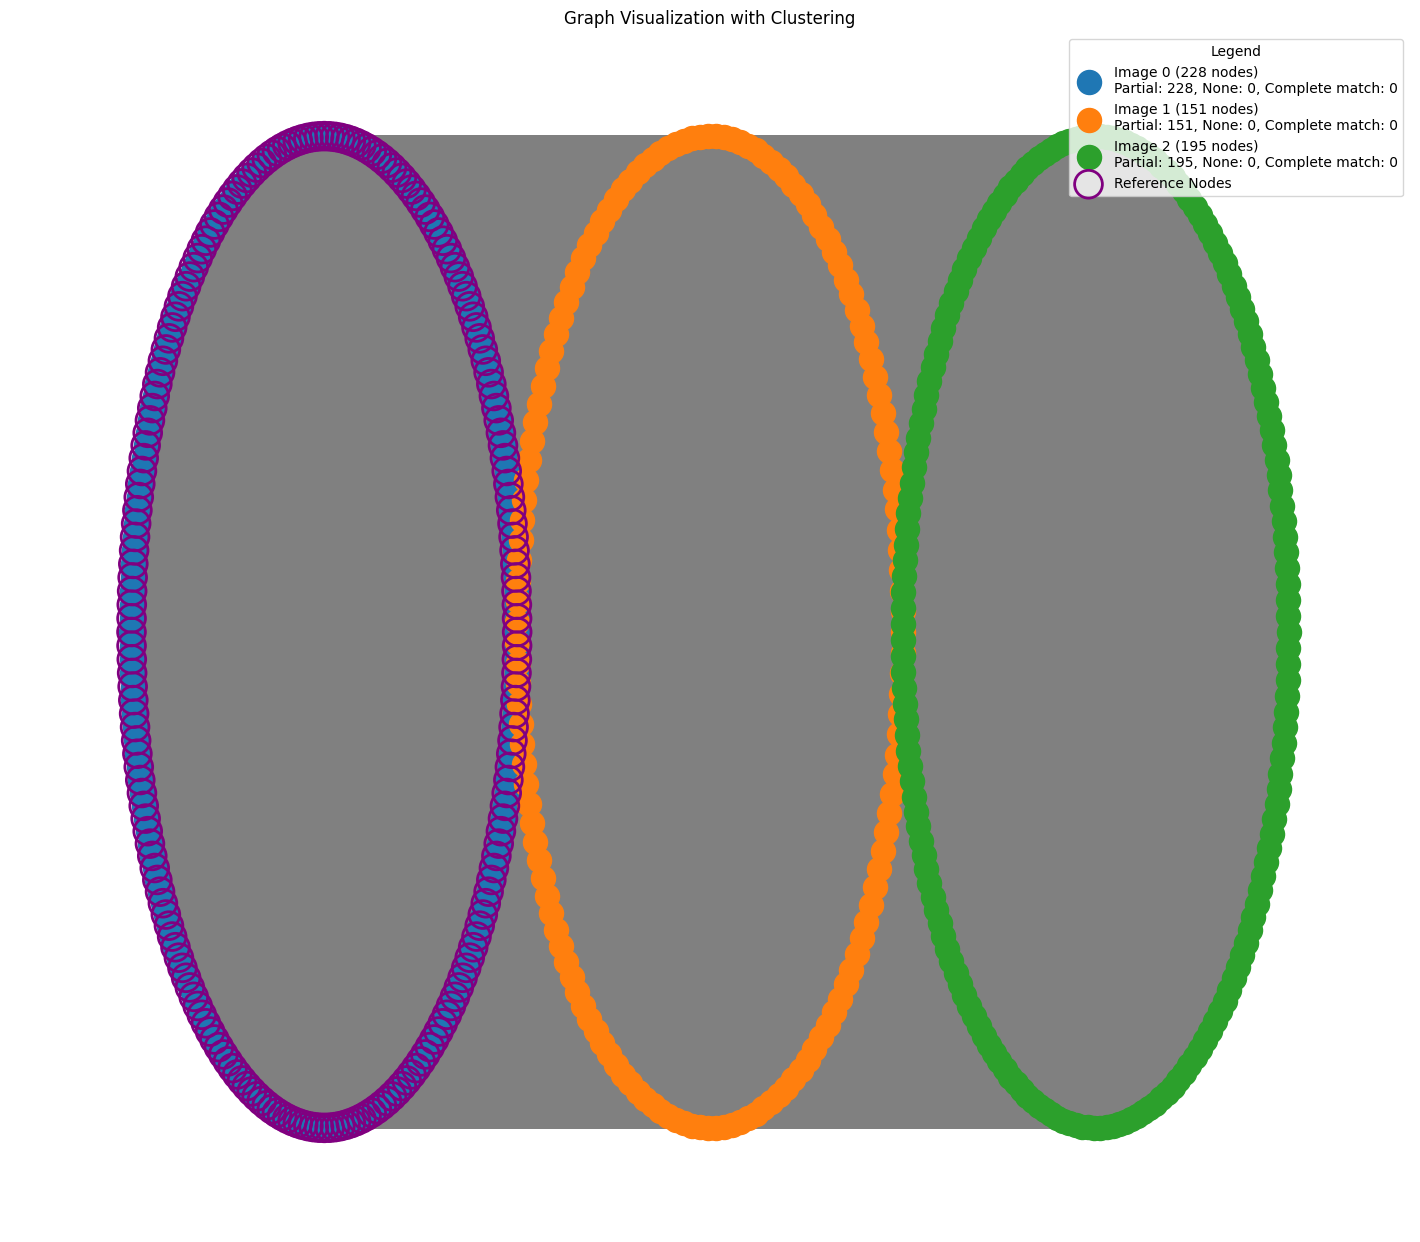

Min pixel value: 0, Max pixel value: 255


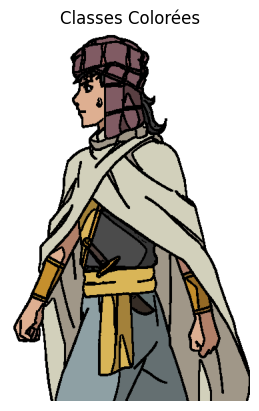

Min pixel value: 0, Max pixel value: 255


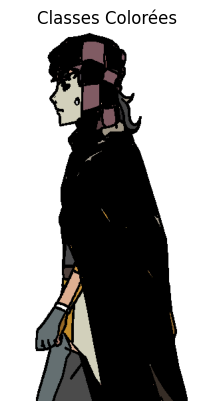

Min pixel value: 0, Max pixel value: 236


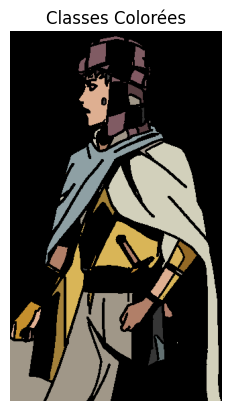

'print("Run connect node 2 ")\nsequence.run2(threshold=float(\'inf\'))'

In [89]:

# Liste des images colorées de test
test_colored_images = [
    cv2.cvtColor(cv2.imread("dataset/colored/sequence3/1.jpg"), cv2.COLOR_BGR2RGB),
    cv2.cvtColor(cv2.imread("dataset/colored/sequence3/7.jpg"), cv2.COLOR_BGR2RGB),
    cv2.cvtColor(cv2.imread("dataset/colored/sequence3/11.jpg"), cv2.COLOR_BGR2RGB)
]

reference_indices = [0]  # La première image est la référence

sequence = Sequence(images = test_colored_images, reference_indices=reference_indices,colored_indices=[i for i in range(len(test_colored_images))])
print("Run connect node 1")
sequence.run(threshold=float('inf')) 

"""print("Run connect node 2 ")
sequence.run2(threshold=float('inf'))""" 


Processing images...
Processing images...
(555, 360)
classe numbers: 229
(556, 293)
classe numbers: 152
(552, 316)
classe numbers: 196
Starting pairwise matching...
Matching Image 0 -> Image 1
Matching Image 1 -> Image 2
Starting reverse matching...
Matching Image 2 -> Image 1
Matching Image 1 -> Image 0
Pairwise matching completed.
Min pixel value: 0, Max pixel value: 255


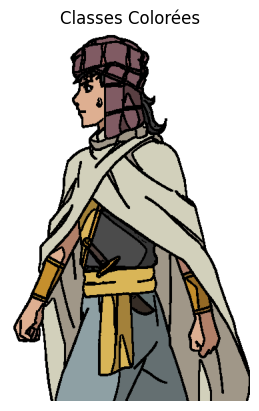

Min pixel value: 0, Max pixel value: 255


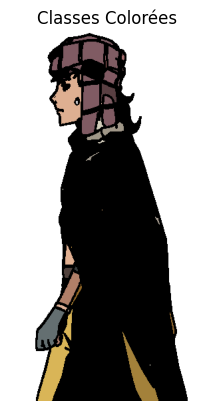

Min pixel value: 0, Max pixel value: 0


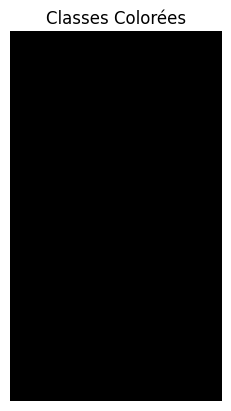

In [113]:
sequence = Sequence(images = test_colored_images, reference_indices=reference_indices,colored_indices=[i for i in range(len(test_colored_images))])

# Exécuter la correspondance pairwise
sequence.runPairwise(match_classes_fct=compute_similarity)

In [ ]:
def compute_similarity(desc1, desc2, weights, color1=None, color2=None, color_tolerance=100):
    """
    Calcule la distance de similarité entre deux ClassDescriptor en fonction de leurs descripteurs, couleurs,
    voisins et patchs environnants.

    Parameters:
        desc1 (dict): Descripteurs de la première classe.
        desc2 (dict): Descripteurs de la seconde classe.
        weights (dict): Pondérations des descripteurs.
        color1 (tuple): Couleur RGB de la première classe.
        color2 (tuple): Couleur RGB de la seconde classe.
        color_tolerance (float): Tolérance pour considérer que les couleurs sont similaires.

    Returns:
        float: La distance de similarité entre les deux classes.
    """
    # Vérification des couleurs
    if color1 is not None and color2 is not None:
        color_distance = np.linalg.norm(np.array(color1) - np.array(color2))
        if color_distance > color_tolerance:
            return float('inf')  # Couleurs trop différentes, pas de match possible

    # Calcul des différences des caractéristiques principales
    aspect_ratio_diff = abs(desc1.get("aspect_ratio", 0) - desc2.get("aspect_ratio", 0))
    centroid_diff = np.linalg.norm(np.array(desc1.get("centroid", [0, 0])) - np.array(desc2.get("centroid", [0, 0])))
    horizontal_max_distance_diff = abs(desc1.get("horizontal_max_distance", 0) - desc2.get("horizontal_max_distance", 0))
    vertical_max_distance_diff = abs(desc1.get("vertical_max_distance", 0) - desc2.get("vertical_max_distance", 0))
    solidity_diff = abs(desc1.get("solidity", 0) - desc2.get("solidity", 0))
    hu_diff = np.linalg.norm(desc1.get("hu_moments", np.zeros(7)) - desc2.get("hu_moments", np.zeros(7)))
    zernike_diff = np.linalg.norm(desc1.get("zernike_moments", np.zeros(25)) - desc2.get("zernike_moments", np.zeros(25)))
    avg_distance_to_centroid_diff = abs(
        desc1.get("avg_distance_to_centroid", 0) - desc2.get("avg_distance_to_centroid", 0)
    )
    difference_image_pos = abs(abs(desc1.get("image_position") - desc2.get("image_position")) - 1)

    # Calcul des différences des patches environnants
    patch_size_diff = abs(desc1.get("patch_size", 0) - desc2.get("patch_size", 0))
    patch_aspect_ratio_diff = abs(desc1.get("patch_aspect_ratio", 0) - desc2.get("patch_aspect_ratio", 0))
    patch_hu_diff = np.linalg.norm(
        desc1.get("patch_hu_moments", np.zeros(7)) - desc2.get("patch_hu_moments", np.zeros(7))
    )

    # Calcul des différences avec les voisins directs
    neighbor_descriptors1 = desc1.get("neighboring_descriptors", {})
    neighbor_descriptors2 = desc2.get("neighboring_descriptors", {})
    neighbor_diff = 0
    common_neighbors = set(neighbor_descriptors1.keys()) & set(neighbor_descriptors2.keys())
    for neighbor in common_neighbors:
        neighbor_desc1 = neighbor_descriptors1[neighbor]
        neighbor_desc2 = neighbor_descriptors2[neighbor]
        neighbor_diff += np.linalg.norm(
            neighbor_desc1.get("hu_moments", np.zeros(7)) - neighbor_desc2.get("hu_moments", np.zeros(7))
        )

    # Somme pondérée des différences
    distance = (
        weights["aspect_ratio"] * aspect_ratio_diff +
        weights["centroid"] * centroid_diff +
        weights["horizontal_max_distance"] * horizontal_max_distance_diff +
        weights["vertical_max_distance"] * vertical_max_distance_diff +
        weights["solidity"] * solidity_diff +
        weights["hu_moments"] * hu_diff +
        weights["zernike_moments"] * zernike_diff +
        weights["avg_distance_to_centroid"] * avg_distance_to_centroid_diff +
        weights["difference_image_pos"] * difference_image_pos**2 +
        weights["patch_size"] * patch_size_diff +
        weights["patch_aspect_ratio"] * patch_aspect_ratio_diff +
        weights["patch_hu_moments"] * patch_hu_diff +
        weights["neighbor_diff"] * neighbor_diff
    )

    return distance



import os
import numpy as np
from scipy.optimize import minimize


class TrainingPipeline:
    def __init__(self, folder, color_tolerance=100):
        self.folder = folder
        self.color_tolerance = color_tolerance
        self.sequences = []  # Liste des séquences de frames
        self.training_data = []  # Données d'entraînement après prétraitement
        self.load_sequences()

    def load_sequences(self):
        """
        Charge toutes les séquences d'images à partir du dossier d'entraînement.
        Chaque sous-sous-dossier représente une séquence.
        """
        print(f"Loading sequences from {self.folder}...")
        for root, dirs, _ in os.walk(self.folder):
            for sub_dir in dirs:
                sub_path = os.path.join(root, sub_dir)
                image_files = sorted([
                    os.path.join(sub_path, f) for f in os.listdir(sub_path)
                    if f.lower().endswith(('.png', '.jpg', '.jpeg'))
                ])
                # Ignorer les séquences avec moins de 2 images
                if len(image_files) > 1:
                    self.sequences.append(image_files)

        if not self.sequences:
            raise ValueError(f"Aucune séquence trouvée dans le dossier : {self.folder}")

        print(f"Total sequences loaded: {len(self.sequences)}")

    def preprocess_sequences(self):
        """
        Prétraite toutes les images pour chaque séquence et extrait les classes.
        """
        print("Preprocessing sequences...")
        for seq_idx, sequence in enumerate(self.sequences):
            print(f"Processing sequence {seq_idx + 1}/{len(self.sequences)}...")
            
            # Créer des ImageDataReference pour toutes les images
            image_data = [ImageDataReference(cv2.imread(
                 
            ), idx) for idx, image in enumerate(sequence)]
            
            for img in image_data:
                img.process_image()  # Traite chaque image pour segmenter et extraire les descripteurs
            self.training_data.append(image_data)


    @staticmethod
    def dict_to_list(weights_dict):
        return list(weights_dict.values())

    @staticmethod
    def list_to_dict(weights_list, keys):
        return {key: weight for key, weight in zip(keys, weights_list)}



def find_matches_based_on_color(image1, image2, color_tolerance):
    """
    Trouve les correspondances entre les classes de deux images en utilisant leurs couleurs dominantes.

    Parameters:
        image1 (ImageDataReference): Première image.
        image2 (ImageDataReference): Deuxième image.
        color_tolerance (float): Tolérance pour la similarité des couleurs.

    Returns:
        dict: Correspondances entre les classes des deux images.
    """
    matches = {}
    for cls1 in image1.classes:
        best_match = None
        min_similarity = float('inf')

        for cls2 in image2.classes:
            # Validation par couleur via compute_similarity
            similarity = compute_similarity(cls1.descriptors, cls2.descriptors, weights={}, 
                                             color1=cls1.color, color2=cls2.color, 
                                             color_tolerance=color_tolerance)
            if similarity < min_similarity:
                min_similarity = similarity
                best_match = cls2

        # Ajouter une correspondance valide
        if best_match and min_similarity < float('inf'):
            matches[cls1.class_id] = best_match.class_id

    return matches


def loss_function_color(weights_dict, training_data, color_tolerance):
    """
    Fonction de perte pour ajuster les pondérations des descripteurs.

    Parameters:
        weights_dict (dict): Pondérations des descripteurs sous forme de dictionnaire.
        training_data (list): Données d'entraînement (séquences d'images).
        color_tolerance (float): Tolérance de couleur.

    Returns:
        float: Perte totale.
    """
    total_loss = 0

    for sequence in training_data:
        for i in range(len(sequence) - 1):
            image1 = sequence[i]
            image2 = sequence[i + 1]

            # Trouver les correspondances basées sur les couleurs et les descripteurs
            matches = find_matches_based_on_color(image1, image2, color_tolerance)

            # Calculer la perte pour chaque correspondance
            for cls1, cls2 in matches.items():
                desc1 = image1.classes[cls1].descriptors
                desc2 = image2.classes[cls2].descriptors

                color1 = image1.classes[cls1].color
                color2 = image2.classes[cls2].color

                # Calculer la similarité
                similarity = compute_similarity(desc1, desc2, weights_dict, color1, color2, color_tolerance)

                # Ajouter une pénalité si la similarité est infinie (mauvais match)
                total_loss += similarity if similarity < float('inf') else 10

    return total_loss



def train(folder, initial_weights_dict, color_tolerance=100):
    """
    Entraîne un modèle pour optimiser les pondérations des descripteurs.

    Parameters:
        folder (str): Dossier contenant les séquences d'entraînement.
        initial_weights_dict (dict): Pondérations initiales sous forme de dictionnaire.
        color_tolerance (float): Tolérance de couleur.

    Returns:
        dict: Pondérations optimisées sous forme de dictionnaire.
    """
    pipeline = TrainingPipeline(folder, color_tolerance)
    pipeline.preprocess_sequences()

    # Convertir le dictionnaire de pondérations en liste pour l'optimisation
    keys = list(initial_weights_dict.keys())
    initial_weights_list = list(initial_weights_dict.values())

    def loss_func(weights_list):
        weights_dict = {key: weight for key, weight in zip(keys, weights_list)}
        return loss_function_color(weights_dict, pipeline.training_data, color_tolerance)

    # Optimisation
    result = minimize(
        fun=loss_func,
        x0=initial_weights_list,
        method='L-BFGS-B',
        bounds=[(0, None)] * len(initial_weights_list)  # Pondérations non négatives
    )

    # Convertir la liste optimisée en dictionnaire
    optimized_weights_dict = {key: weight for key, weight in zip(keys, result.x)}
    return optimized_weights_dict






## Pondérations initiales sous forme de dictionnaire
initial_weights_dict = {
    "aspect_ratio": 0.1,
    "centroid": 0.1,
    "horizontal_max_distance": 0.15,
    "vertical_max_distance": 0.15,
    "solidity": 0.15,
    "hu_moments": 0.2,
    "zernike_moments": 0.15,
    "avg_distance_to_centroid": 0.05,
    "difference_image_pos": 100,
    "patch_size": 0.1,
    "patch_aspect_ratio": 0.05,
    "patch_hu_moments": 0.2,
    "neighbor_diff": 0.05,
}
train_pipeline = TrainingPipeline(folder="dataset/frame_from_videos/")

optimized_weights = train(folder="dataset/frame_from_videos/",initial_weights_dict=initial_weights_dict, )
import json
with open("optimized_weights.json", "w") as f:
    json.dump(optimized_weights, f)

print("Optimized Weights:", optimized_weights)


Loading sequences from dataset/frame_from_videos/...
Total sequences loaded: 2970
Loading sequences from dataset/frame_from_videos/...
Total sequences loaded: 2970
Preprocessing sequences...
Processing sequence 1/2970...
(1080, 1920)
classe numbers: 268
(1080, 1920)
classe numbers: 293
(1080, 1920)
classe numbers: 292
(1080, 1920)
classe numbers: 315
(1080, 1920)
classe numbers: 304
(1080, 1920)
classe numbers: 309
(1080, 1920)
classe numbers: 306
(1080, 1920)
classe numbers: 273
(1080, 1920)
classe numbers: 329
(1080, 1920)
classe numbers: 270
(1080, 1920)
classe numbers: 303
(1080, 1920)
classe numbers: 321
(1080, 1920)
classe numbers: 299
(1080, 1920)
classe numbers: 289
Processing sequence 2/2970...
(1080, 1920)
classe numbers: 6701
(1080, 1920)
classe numbers: 6944
(1080, 1920)
classe numbers: 6425
Processing sequence 3/2970...
(1080, 1920)
classe numbers: 6124
(1080, 1920)
classe numbers: 7034
(1080, 1920)


In [79]:

#brouillons
def find_minimum_paths(self):
        """
        Trouve les correspondances itératives avec les règles :
        - Une référence ne peut pas matcher avec une autre référence.
        - Une référence conserve toujours sa couleur d'origine.
        - Une classe devient une référence après avoir été associée à une autre classe.
        """
        paths = []
        remaining_graph = self.graph.copy()
        processed_references = set()  # Nodes qui sont des références fixes et ne peuvent plus être modifiées

        while True:
            iteration_paths = []
            used_images = set()  # Images déjà utilisées dans cette itération

            for ref_node, data in list(remaining_graph.nodes(data=True)):
                # Ne traiter que les nodes qui sont des références et non "fixées"
                if not data.get("is_reference", False) or ref_node in processed_references:
                    continue

                ref_image = data["image_id"]
                closest_matches = []

                # Trouver les candidats de match valides
                for neighbor in list(remaining_graph.neighbors(ref_node)):
                    neighbor_data = remaining_graph.nodes[neighbor]
                    neighbor_image = neighbor_data["image_id"]

                    # Vérifier les contraintes
                    if neighbor_image == ref_image:  # Pas de match avec une classe de la même image
                        continue
                    if neighbor in processed_references:  # Pas de match avec une autre référence
                        continue
                    if neighbor_image in used_images:  # Une seule connexion par image
                        continue

                    edge_weight = remaining_graph[ref_node][neighbor]["weight"]
                    closest_matches.append((edge_weight, neighbor))

                # Trier les candidats par poids
                closest_matches.sort(key=lambda x: x[0])

                if closest_matches:
                    # Sélectionner le meilleur match
                    _, best_match = closest_matches[0]

                    iteration_paths.append([ref_node, best_match])
                    used_images.add(remaining_graph.nodes[best_match]["image_id"])

            # Ajouter les correspondances trouvées
            paths.extend(iteration_paths)

            # Marquer les nodes associées comme des références
            for ref_node, match_node in iteration_paths:
                remaining_graph.nodes[match_node]["is_reference"] = True
                processed_references.add(match_node)

            # Supprimer les nodes associées pour éviter de les réutiliser
            matched_nodes = set(node for pair in iteration_paths for node in pair)
            remaining_graph.remove_nodes_from(matched_nodes)

            # Arrêter si aucune correspondance n'a été trouvée
            if not iteration_paths:
                break

        return paths



def find_minimum_paths(self):
        """
        Propagation des couleurs dans le graphe :
        - Les nœuds de référence sont appariés à un nœud de chaque image.
        - Une fois apparié, un nœud devient lui-même une référence.
        - Supprime les arêtes inutiles au fur et à mesure.
        """
        remaining_edges = list(self.graph.edges(data=True))  # Travail sur les arêtes restantes
        assigned_nodes = set()  # Nœuds déjà assignés à une référence
        reference_nodes = {node for node, data in self.graph.nodes(data=True) if data["is_reference"]}
        
        while remaining_edges:
            progress = False  # Pour suivre si des changements ont été effectués dans l'itération

            for ref_node in list(reference_nodes):
                ref_color = self.graph.nodes[ref_node]["color"]
                ref_image_id = self.graph.nodes[ref_node]["image_id"]

                # Trouver les arêtes candidates pour cette référence
                candidate_edges = [
                    (u, v, data)
                    for u, v, data in remaining_edges
                    if (u == ref_node or v == ref_node)
                    and (u if u != ref_node else v) not in assigned_nodes
                    and self.graph.nodes[u]["image_id"] != self.graph.nodes[v]["image_id"]
                ]

                if not candidate_edges:
                    continue  # Passer si aucune correspondance n'est possible pour cette référence

                # Trier les candidats par poids (distance minimale en premier)
                candidate_edges.sort(key=lambda x: x[2]["weight"])
                best_edge = candidate_edges[0]
                _, match_node = (best_edge[0], best_edge[1]) if best_edge[0] == ref_node else (best_edge[1], best_edge[0])

                # Mettre à jour la couleur et marquer le nœud comme assigné
                self.graph.nodes[match_node]["color"] = ref_color
                assigned_nodes.add(match_node)
                progress = True

                # Transformer le nœud assigné en une nouvelle référence
                self.graph.nodes[match_node]["is_reference"] = True
                reference_nodes.add(match_node)

                # Supprimer toutes les arêtes connectées au match_node dans le même groupe d'images
                remaining_edges = [
                    (u, v, data)
                    for u, v, data in remaining_edges
                    if not (u == match_node or v == match_node)
                    or (self.graph.nodes[u]["image_id"] == self.graph.nodes[v]["image_id"])
                ]

            if not progress:
                break  # Arrêter si aucune mise à jour n'a été effectuée

        return assigned_nodes

        """

SyntaxError: incomplete input (2830250519.py, line 128)